# Regression with an Abalone Dataset
Run after following notebooks are run:
1. **01_Data_Cleaning**
2. **02_EDA**

## Development Notes/Ideas
- rf
- xgb
- knn
- lasso
- stack
- convert Rings to ordinal categories - this way voting will choose majority vote rather than averaging


## Libraries

In [1]:
## set up libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

## Load Data

In [2]:
train = pd.read_pickle('train_clean.pkl')
test = pd.read_pickle('test_clean.pkl')

## separate in to features and response variable
x_train = train.drop('Rings', axis=1)
y_train = train['Rings']

x_test = test

## One Hot Encoding

In [3]:
x_train_onehot = pd.get_dummies(x_train, drop_first=True)
x_test_onehot = pd.get_dummies(x_test, drop_first=True)
print("train dimensions: ", x_train_onehot.shape, "\n","test dimensions: ", x_test_onehot.shape)
x_train_onehot.columns.to_list()

train dimensions:  (90615, 11) 
 test dimensions:  (60411, 11)


['Length',
 'Diameter',
 'Height',
 'Whole weight',
 'Whole weight.1',
 'Whole weight.2',
 'Shell weight',
 'Volume_cube',
 'Density_meat',
 'Sex_I',
 'Sex_M']

## Modelling
### Random Forest

In [4]:
## hyperparameter tuning: n_estimators
param_grid = {'n_estimators' : np.arange(300,450,50), 'n_jobs' : [-1]}
kf = KFold(n_splits=5, shuffle=True, random_state=888)

rf_tuning = GridSearchCV(RandomForestRegressor(random_state=888), param_grid, scoring='neg_mean_squared_log_error', cv=kf, n_jobs=-1)
rf_tuning.fit(x_train_onehot.values, y_train)
None

In [5]:
## find best param with highest accuracy
rf_tuning_accr = rf_tuning.cv_results_['mean_test_score']
print('best_params =', rf_tuning.best_params_)
print('best_score =', rf_tuning.best_score_)
rf_tuning_accr

best_params = {'n_estimators': 400, 'n_jobs': -1}
best_score = -0.002116464972825535


array([-0.00211814, -0.00211721, -0.00211646])

In [6]:
## instantiate rf algorithm, using best tuned param
rf = RandomForestRegressor(n_estimators=400, random_state=888, n_jobs=-1)

## fit model to training data
rf.fit(x_train_onehot.values, y_train); None

#### Feature importance

In [7]:
## List feature importance
rf_ft_imp = pd.DataFrame(data={'Features': x_train_onehot.columns, 'Gini Importance':rf.feature_importances_*100})
rf_ft_imp.sort_values(by='Gini Importance', ascending=False)

,Features,Gini Importance
6,Shell weight,64.176353
8,Density_meat,8.978309
4,Whole weight.1,6.238470
3,Whole weight,4.850089
5,Whole weight.2,4.370962
7,Volume_cube,3.394460
0,Length,2.912683
1,Diameter,2.299838
2,Height,1.521654
9,Sex_I,0.844384


## Test Predictions

In [8]:
## set up submission format - i.e. Id & NObeyesdad
id = np.arange(len(train), len(train)+len(test))
submission = pd.DataFrame(data={'id':id, 'Rings':''})

In [9]:
## rf prediction
y_testpred_rf = rf.predict(x_test_onehot.values)
y_testpred_rf = np.exp(y_testpred_rf)-1
y_testpred_rf = np.round(y_testpred_rf)
submission['Rings'] = y_testpred_rf
submission.to_csv('Submissions/test_pred_rf_v2.csv', index=False)

CHECK count of Rings==28 : 0


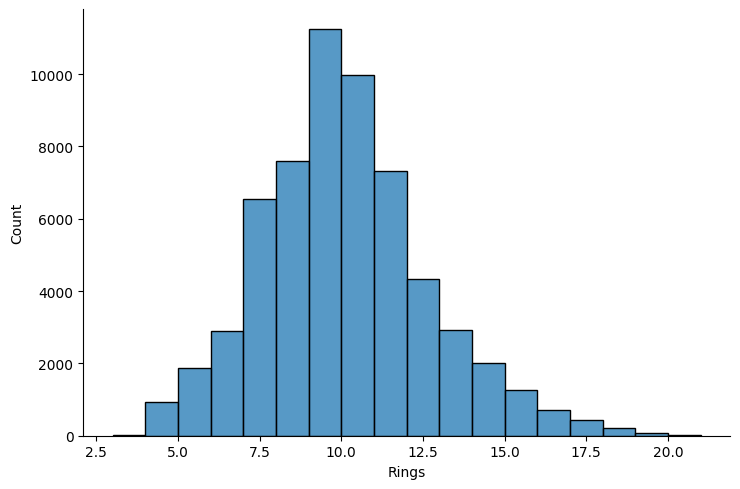

In [10]:
## CHECKS
## check Rings!=28
print('CHECK count of Rings==28 :',sum(submission.Rings==28))

## test prediction histogram of Rings
g=sns.displot(data=submission, x='Rings', binwidth=1, aspect=1.5)